In [1]:
from matplotlib import pyplot
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, time

from summer.utils import ref_times_to_dti

from autumn.tools.inputs.mobility.queries import get_mobility_data
from autumn.tools.inputs.database import get_input_db
from autumn.tools.project import get_project
from autumn.tools.utils.utils import apply_moving_average
from autumn.tools.plots.utils import REF_DATE
from autumn.tools.curve.scale_up import scale_up_function
from autumn.tools.utils.pretty import pretty_print
from autumn.models.sm_sir.preprocess.age_specific_params import convert_param_agegroups
from autumn.models.sm_sir.model import get_compartments
from autumn.tools.inputs import get_population_by_agegroup
from autumn.tools.inputs.social_mixing.build_synthetic_matrices import build_synthetic_matrices
from autumn.models.covid_19.detection import create_cdr_function, get_testing_numbers_for_region
from autumn.models.covid_19.mixing_matrix.macrodistancing import weight_mobility_data

In [2]:
warnings.filterwarnings("ignore")
pyplot.style.use("ggplot")

region = "malaysia"
project = get_project("sm_sir", region)

In [14]:
baseline_params = project.param_set.baseline
custom_params = project.param_set.baseline.update(
    {'contact_rate': 0.1,
    }
)
model = project.run_baseline_model(custom_params)
derived_df = model.get_derived_outputs_df()

### Model structure

In [15]:
print(f"Model compartments are: {list(set([comp.name for comp in model.compartments]))}")
model_stratifications = [strat.name for strat in model._stratifications]
print(f"Model stratifications are: {[strat.name for strat in model._stratifications]}")
for i_strat, strat in enumerate(model_stratifications):
    print(f"\tStrata for stratification {strat} are {model._stratifications[i_strat].strata}")

Model compartments are: ['susceptible', 'latent', 'infectious', 'recovered']
Model stratifications are: ['agegroup', 'clinical', 'immunity']
	Strata for stratification agegroup are ['0', '15', '25', '50', '70']
	Strata for stratification clinical are ['asympt', 'sympt_non_detect', 'detect']
	Strata for stratification immunity are ['none', 'high', 'low']


### Model times

In [16]:
model_start_time = ref_times_to_dti(REF_DATE, [project.param_set.baseline["time"]["start"]])[0]
model_end_time = ref_times_to_dti(REF_DATE, [project.param_set.baseline["time"]["end"]])[0]

start_string = model_start_time.strftime("%d/%m/%Y")
end_string = model_end_time.strftime("%d/%m/%Y")
print(f"Baseline model running from {start_string} to {end_string}")

Baseline model running from 29/05/2021 to 20/01/2022


### Clinical parameters

2022-01-24 15:33:08.331 INFO    matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-01-24 15:33:08.333 INFO    matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


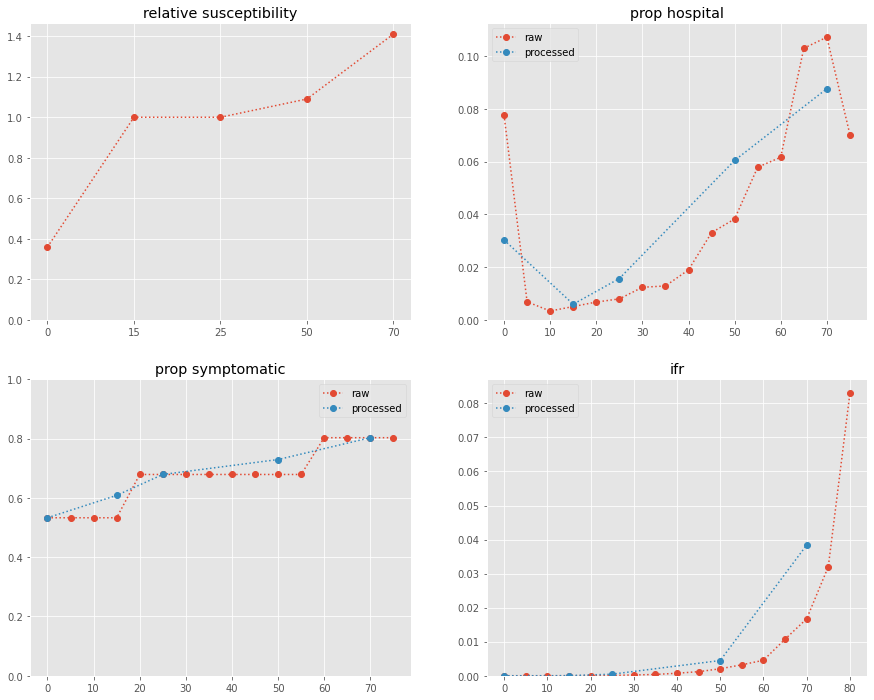

In [17]:
age_params = baseline_params["age_stratification"]
age_groups = baseline_params["age_groups"]
standard_agegroups = range(0, 80, 5)
ifr_age_groups = range(0, 85, 5)

# Susceptibility
fig = pyplot.figure(figsize=(15, 12))
axis = fig.add_subplot(2, 2, 1)
axis.plot(
    age_params["susceptibility"].keys(), 
    age_params["susceptibility"].values(),
    marker="o",
    linestyle=":",
)
axis.set_title("relative susceptibility")
axis.set_ylim(bottom=0.)

# Clinical proportions
for i_prop, clin_prop in enumerate(["prop_hospital", "prop_symptomatic", "ifr"]):
    
    base_agegroups = ifr_age_groups if clin_prop == "ifr" else standard_agegroups
    upper_y = 1. if clin_prop == "prop_symptomatic" else None
    
    axis = fig.add_subplot(2, 2, 2 + i_prop)
    axis.plot(
        base_agegroups, 
        age_params[clin_prop],
        marker="o",
        linestyle=":",
        label="raw",
    )
    axis.plot(
        age_groups,
        convert_param_agegroups(
            age_params[clin_prop], 
            baseline_params["country"]["iso3"], 
            baseline_params["population"]["region"], 
            age_groups
        ),
        marker="o",
        linestyle=":",
        label="processed",    
    )
    axis.set_title(clin_prop.replace("_", " "))
    axis.set_ylim(bottom=0., top=upper_y)
    axis.legend()


### Population

Total population simulated is 32.365999 million
Infectious seed is 200


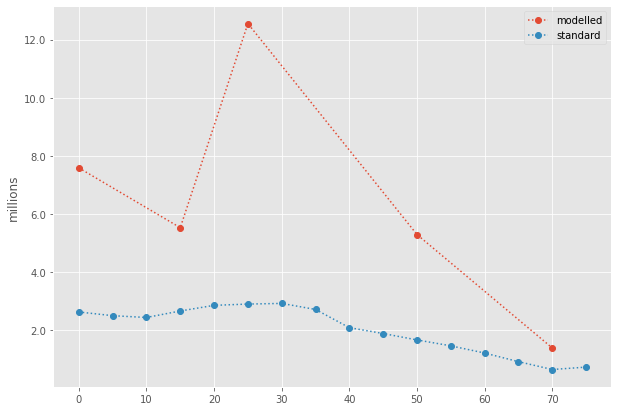

In [7]:
iso3 = baseline_params["country"]["iso3"]
subregion = baseline_params["population"]["region"]
year = baseline_params["population"]["year"]


def yaxis_millions(axis_to_adjust):
    
    def millions(x, pos):
        return f"{(x * 1e-6)}"

    axis_to_adjust.yaxis.set_major_formatter(FuncFormatter(millions))
    axis_to_adjust.set_ylabel("millions")


model_pops = get_population_by_agegroup(age_groups, iso3, subregion, year)
standard_pops = get_population_by_agegroup(standard_agegroups, iso3, subregion, year)
print(f"Total population simulated is {sum(standard_pops) / 1e6} million")
print(f"Infectious seed is {baseline_params['infectious_seed']}")

fig = pyplot.figure(figsize=(10, 7))
axis = fig.add_subplot()

axis.plot(
    age_groups, 
    model_pops,
    marker="o",
    linestyle=":",
    label="modelled",
)
axis.plot(
    standard_agegroups, 
    standard_pops,
    marker="o",
    linestyle=":",
    label="standard"
)
yaxis_millions(axis)
axis.legend()


### Mixing matrices

Parameters used in mixing matrix construction:
	Modelled country: MYS
	Modelled sub-region: None
	Proxy country: CHN
	Assumed age adjusted (hard coded)


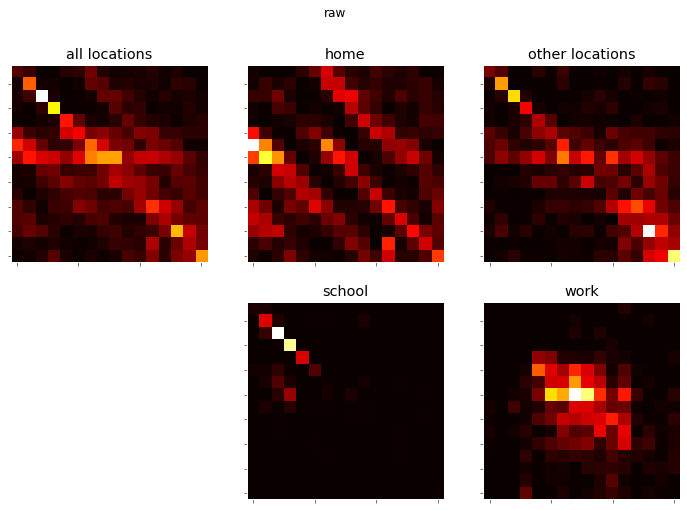

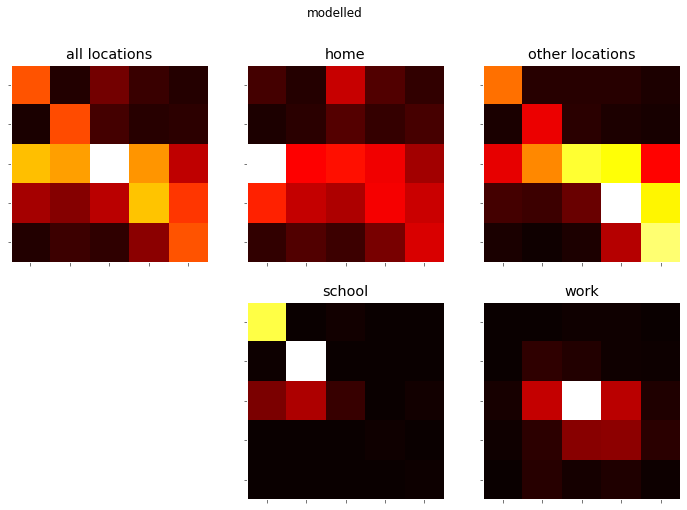

In [8]:
def plot_matrices(mixing_matrices, title):
    fig = pyplot.figure(figsize=(12, 8))
    positions = [1, 2, 3, 5, 6]
    for i_loc, location in zip(positions, mixing_matrices.keys()):
        ax = fig.add_subplot(2, 3, i_loc)
        ax.imshow(
            np.flipud(np.transpose(mixing_matrices[location])), 
            cmap=cm.hot, 
            vmin=0,
            vmax=mixing_matrices[location].max(), 
            origin="lower"
        )
        ax.set_title(location.replace("_", " "))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(False)
    fig.suptitle(title)

ref_iso3 = baseline_params["ref_mixing_iso3"]
matrices = build_synthetic_matrices(iso3, ref_iso3, standard_agegroups, True, subregion)
plot_matrices(matrices, "raw") 
matrices = build_synthetic_matrices(iso3, ref_iso3, age_groups, True, subregion)
plot_matrices(matrices, "modelled")

print("Parameters used in mixing matrix construction:")
print(f"\tModelled country: {baseline_params['country']['iso3']}")
print(f"\tModelled sub-region: {baseline_params['population']['region']}")
print(f"\tProxy country: {baseline_params['ref_mixing_iso3']}")
print(f"\tAssumed age adjusted (hard coded)")

### Mobility

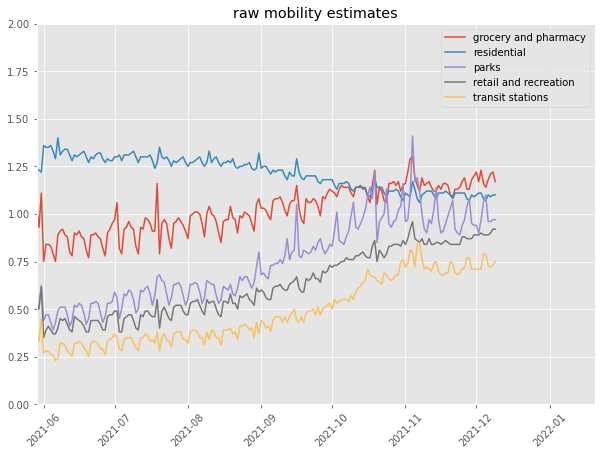

In [9]:
input_db = get_input_db()
mob_df = input_db.query("mobility", conditions={"iso3": iso3, "region": None})

fig = pyplot.figure(figsize=(10, 7))
axis = fig.add_subplot(1, 1, 1)

times = [datetime.strptime(i, "%Y-%m-%d") for i in mob_df["date"]]
for mobility_domain in ["grocery_and_pharmacy", "residential", "parks", "retail_and_recreation", "transit_stations"]:
    axis.plot(times, mob_df[mobility_domain], label=mobility_domain.replace("_", " "))
axis.set_ylim([0., 2.])
axis.tick_params(axis="x", labelrotation=45)
axis.set_title("raw mobility estimates")
axis.set_xlim([model_start_time, model_end_time])
axis.legend()

(18776.0, 19012.0)

<Figure size 720x504 with 0 Axes>

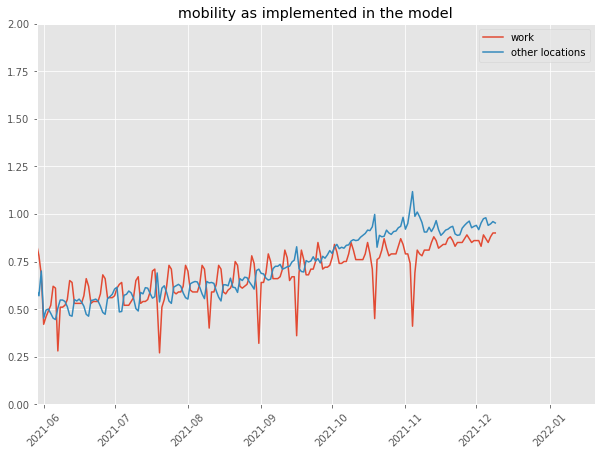

In [10]:
fig = pyplot.figure(figsize=(10, 7))

mobility_params = baseline_params["mobility"]

mobility_values, mobility_days = get_mobility_data(iso3, None, datetime(2019, 12, 31, 0, 0, 0))

google_mobility_values = weight_mobility_data(mobility_values, mobility_params["google_mobility_locations"])
times = ref_times_to_dti(REF_DATE, mobility_days)
locations = list(mobility_params["google_mobility_locations"].keys())

fig = pyplot.figure(figsize=(10, 7))
axis = fig.add_subplot(1, 1, 1)
for location in locations:
    axis.plot(times, google_mobility_values[location], label=location.replace("_", " "))
axis.tick_params(axis="x", labelrotation=45)
axis.set_title("mobility as implemented in the model")
axis.set_ylim((0., 2.))
axis.legend()
axis.set_xlim([model_start_time, model_end_time])

### Case detection

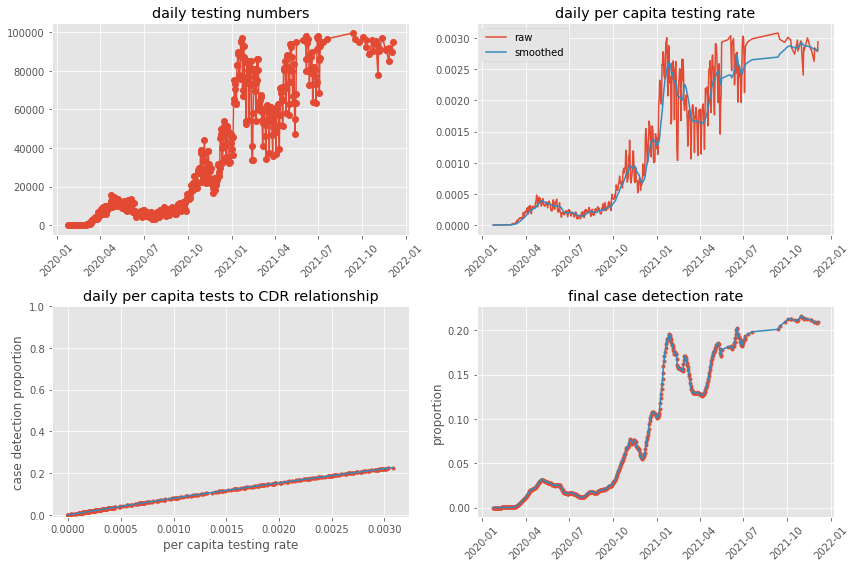

In [11]:
# Get the CDR function of tests
cdr_from_tests_func = create_cdr_function(
    baseline_params["testing_to_detection"]["assumed_tests_parameter"],
    baseline_params["testing_to_detection"]["assumed_cdr_parameter"],
)

# Get the denominator population
total_pop = sum(model_pops)

# Pre-processing
test_ints, test_values = get_testing_numbers_for_region(iso3, subregion)
test_dates = ref_times_to_dti(REF_DATE, [int(time) for time in test_ints])
per_capita_tests = [i_tests / total_pop for i_tests in test_values]
dummy_tests = np.linspace(0, max(per_capita_tests), 200)
smoothed_per_capita_tests = apply_moving_average(
    per_capita_tests, baseline_params["testing_to_detection"]["smoothing_period"]
)
cdr_function_of_time = scale_up_function(
    test_ints,
    [cdr_from_tests_func(test_rate) for test_rate in smoothed_per_capita_tests],
    smoothness=0.2, method=4, bound_low=0.,
)    

# Plot
fig = pyplot.figure(figsize=(12, 8))

# Plot daily number of tests
axis = fig.add_subplot(2, 2, 1)
axis.plot(test_dates, test_values, marker="o")
axis.tick_params(axis="x", labelrotation=45)
axis.set_title("daily testing numbers")

# Plot daily number of tests
axis = fig.add_subplot(2, 2, 2)
axis.plot(test_dates, per_capita_tests, label="raw")
axis.plot(test_dates, smoothed_per_capita_tests, label="smoothed")
axis.tick_params(axis="x", labelrotation=45)
axis.set_title("daily per capita testing rate")
axis.legend()

# Plot relationship of daily tests to CDR proportion
axis = fig.add_subplot(2, 2, 3)
axis.plot(
    per_capita_tests, 
    [cdr_from_tests_func(i_tests) for i_tests in per_capita_tests],
    marker=".",
    linestyle=" "
)
axis.plot(dummy_tests, cdr_from_tests_func(dummy_tests))
axis.set_ylabel("case detection proportion")
axis.set_xlabel("per capita testing rate")
axis.set_title("daily per capita tests to CDR relationship")
axis.set_ylim(top=1.)

# Plot CDR values
axis = fig.add_subplot(2, 2, 4)
axis.plot(
    test_dates, 
    [cdr_from_tests_func(i_test_rate) for i_test_rate in smoothed_per_capita_tests], 
    marker=".", 
    linestyle=" ",
)
axis.plot(
    test_dates, 
    [cdr_function_of_time(time) for time in test_ints],
)
axis.set_title("final case detection rate")
axis.set_ylabel("proportion")
axis.tick_params(axis="x", labelrotation=45)

fig.tight_layout()

### Targets

In [12]:
pretty_print(baseline_params)

Params
{ 'activate_random_process': False,
  'age_groups': [0, 15, 25, 50, 70],
  'age_stratification': { 'ifr': [ 3e-05,
                                   1e-05,
                                   1e-05,
                                   3e-05,
                                   6e-05,
                                   0.00013,
                                   0.00024,
                                   0.0004,
                                   0.00075,
                                   0.00121,
                                   0.00207,
                                   0.00323,
                                   0.00456,
                                   0.01075,
                                   0.01674,
                                   0.03203,
                                   0.08292],
                          'prop_hospital': [ 0.0777,
                                             0.0069,
                                             0.0034,
                       

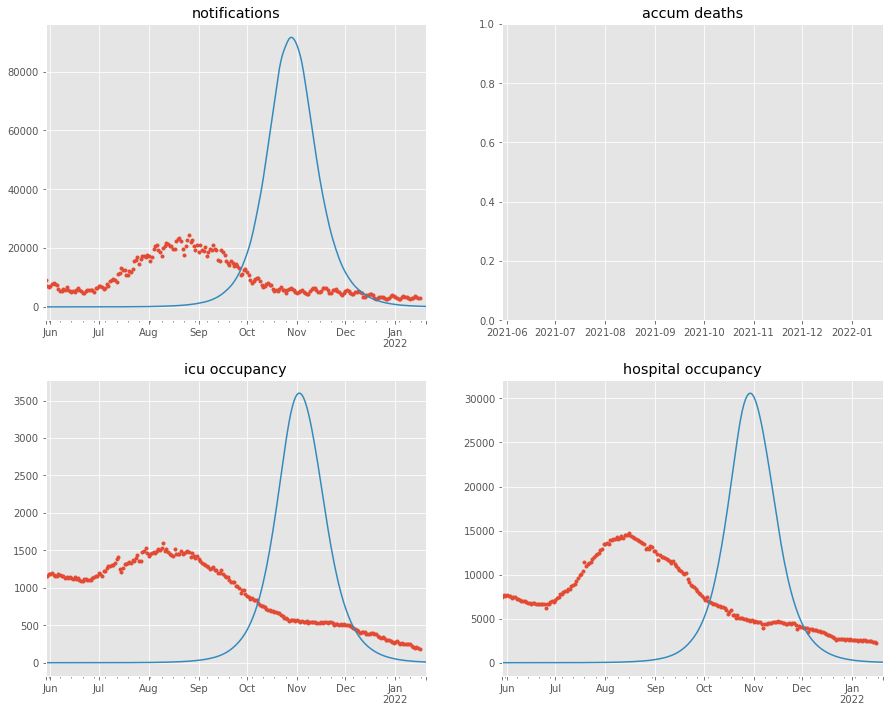

In [13]:
targets_dict = {
    t.data.name: pd.Series(t.data.data, index=ref_times_to_dti(model.ref_date, t.data.index)) for 
    t in project.calibration.targets
}
death_string = "accum_deaths" if region == "bangladesh" else "infection_deaths"
outputs_to_plot = ["notifications", "accum_deaths", "icu_occupancy", "hospital_occupancy"]

fig = pyplot.figure(figsize=(15, 12))
for i_out, output in enumerate(outputs_to_plot):
    axis = fig.add_subplot(2, 2, i_out + 1)
    if output in targets_dict:
        targets_dict[output].plot(ax=axis, style='.')
    if output in derived_df:
        derived_df[output].plot(ax=axis)
    axis.set_title(output.replace("_", " "))
    axis.set_xlim([model_start_time, model_end_time])
    